# Feeder Data Statistical Analysis

This is severely limited by T&TEC's data. The exploration was guided by the approach taken by <a href="https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python">Banerjee</a> in analysing time-series.

# Setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt   # data visualization

import seaborn as sns             # statistical data visualization



In [11]:
mpl.rcParams['figure.dpi'] = 150

%matplotlib inline

In [4]:
df = pd.read_csv('../data/load_statistical_analysis/aranguez_feeder_data.csv',parse_dates=[0])
df.set_index('Timestamp',inplace=True)
df.drop(['Times'],inplace=True,axis=1)
df.head()

,S total_SJN,P total_SJN,Q total_SJN,pf total_SJN
Timestamp,,,,
2016-02-25 08:30:00,3161.467,3115.421,536.674,-98.546
2016-02-25 08:15:00,3056.149,3015.793,492.922,-98.685
2016-02-25 08:00:00,3022.004,2985.381,467.788,-98.791
2016-02-25 07:45:00,3044.149,3013.303,430.548,-98.990
2016-02-25 07:30:00,2968.528,2950.797,322.232,-99.405


In [76]:
df.tail()

,S total_SJN,P total_SJN,Q total_SJN,pf total_SJN
Timestamp,,,,
2016-01-01 01:00:00,13961.358,13551.752,3357.015,0.971
2016-01-01 00:45:00,14039.635,13630.260,3365.615,0.971
2016-01-01 00:30:00,14160.296,13751.502,3377.893,0.971
2016-01-01 00:15:00,14358.196,13940.001,3440.082,0.971
2016-01-01 00:00:00,14548.624,14134.821,3445.183,0.972


In [5]:
df_proc = df.resample('15T').asfreq().sort_index(ascending=False)

In [6]:
# Check for missing segments in the fixed frequency DataFrame
missing_segments = df_proc[df_proc.isna().any(axis=1)]

# Print the missing segments, if any
if len(missing_segments) > 0:
    print("Missing segments:")
    print(missing_segments)
else:
    print("No missing segments.")


No missing segments.


In [7]:
df_proc = df_proc.interpolate('linear')

# Time Series Analysis

The below code analyzes the time-series for periodicity, trend and seasonality to determine if there is significant volatility as well as what trends are common so they can be used to develop representative feeder base loads. An investigation into the anomalies of the dataset is not done since the data appears clean at first glance.

## Behaviour over different intervals

The data is plotted over the course of the months and then weeks below.

In [8]:
def plot_df(df, y, title="", xlabel='Date', ylabel='Magnitude', dpi=150):
    plt.figure(figsize=(12,4), dpi=dpi)
    plt.plot(y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.grid()
    plt.show()

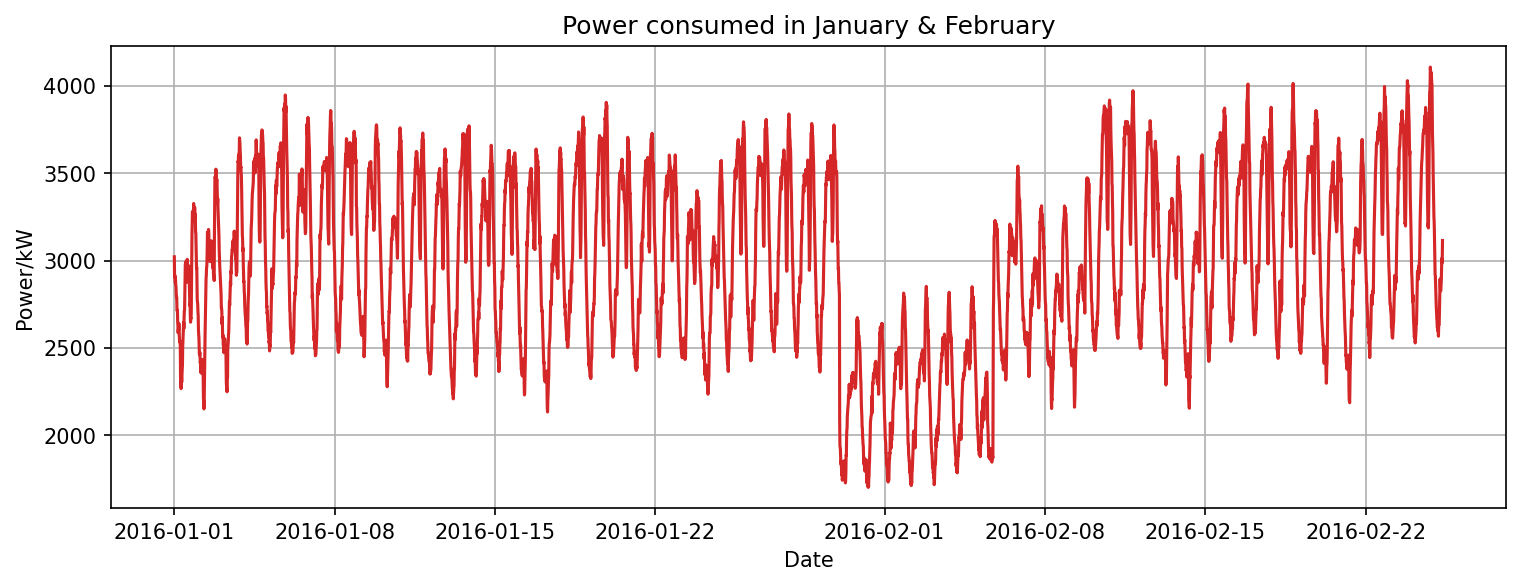

In [9]:
plot_df(df, y=df['P total_SJN'], title='Power consumed in January & February',ylabel='Power/kW')

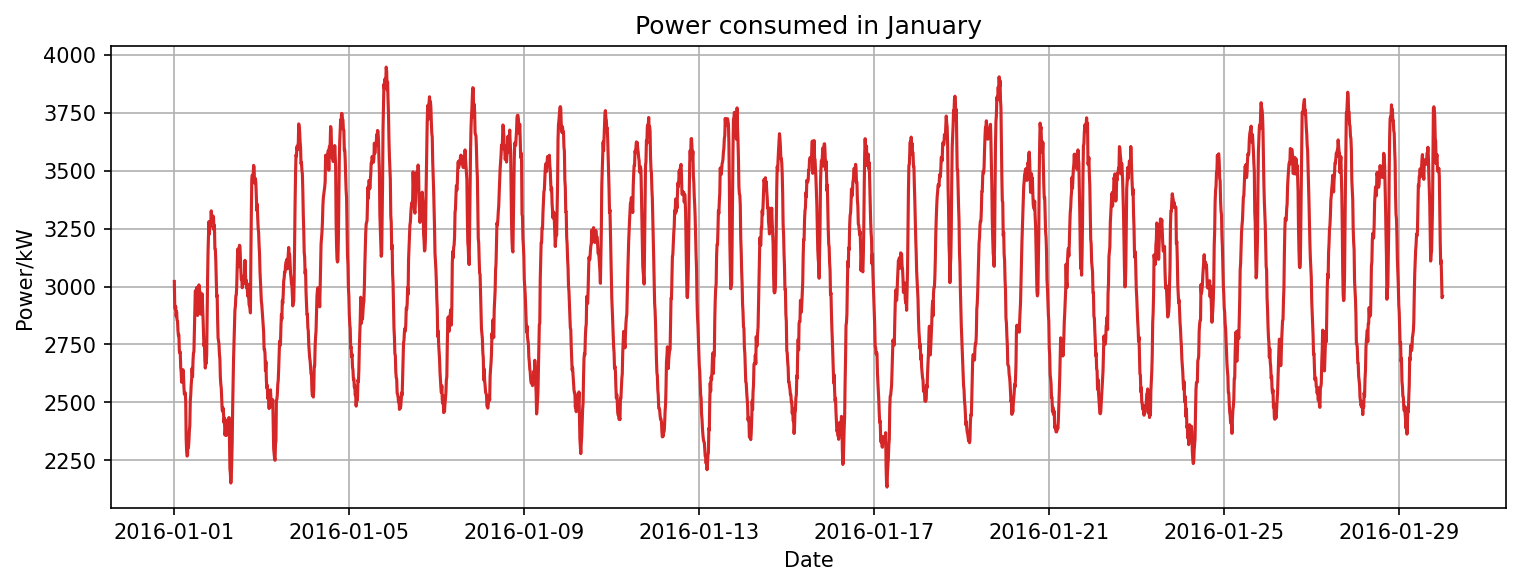

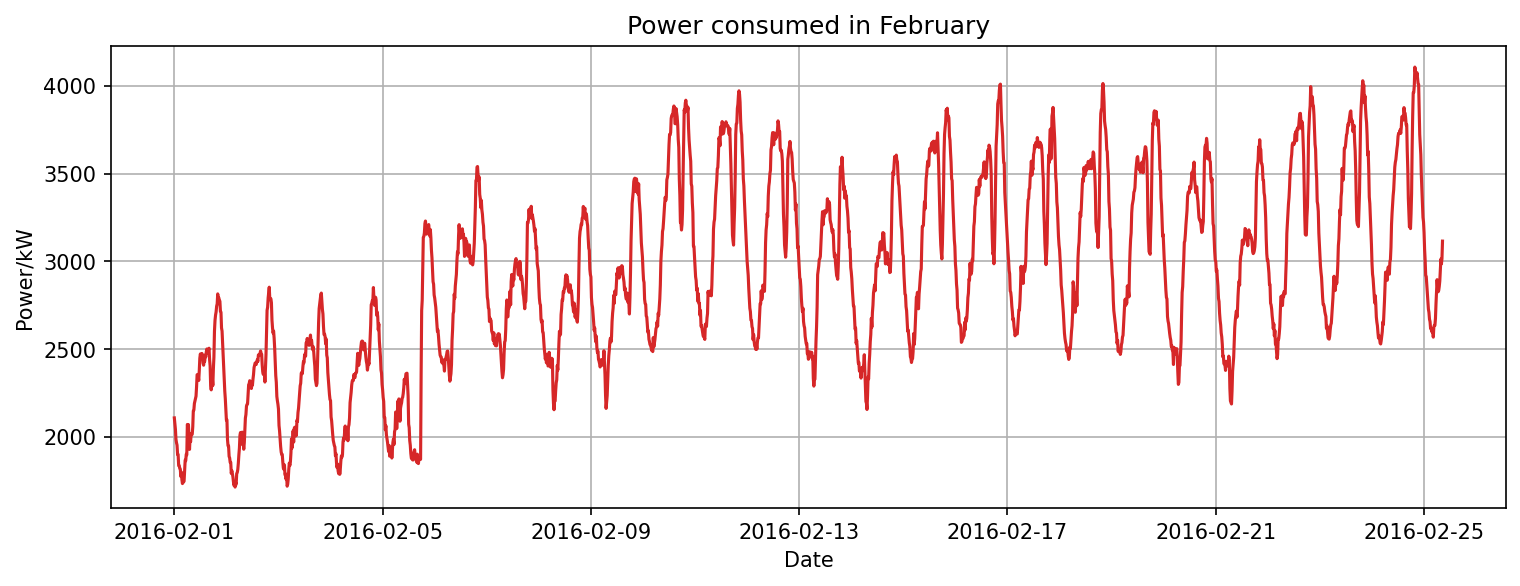

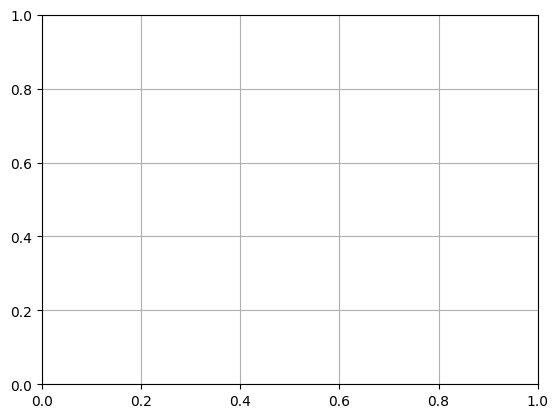

In [10]:
plot_df(df, y=df['P total_SJN']['2016-01-01':'2016-01-29'], title='Power consumed in January',ylabel='Power/kW')
plot_df(df, y=df['P total_SJN']['2016-02-01':], title='Power consumed in February',ylabel='Power/kW')
plt.grid()

From the above, the data seems to have a noticeable drop transitioning from January to February. It appears that the data is cyclostationary or possibly seasonal in nature. However, further investigation is needed. It would be interesting to see how the data varies weekly as well.

<AxesSubplot:xlabel='Timestamp'>

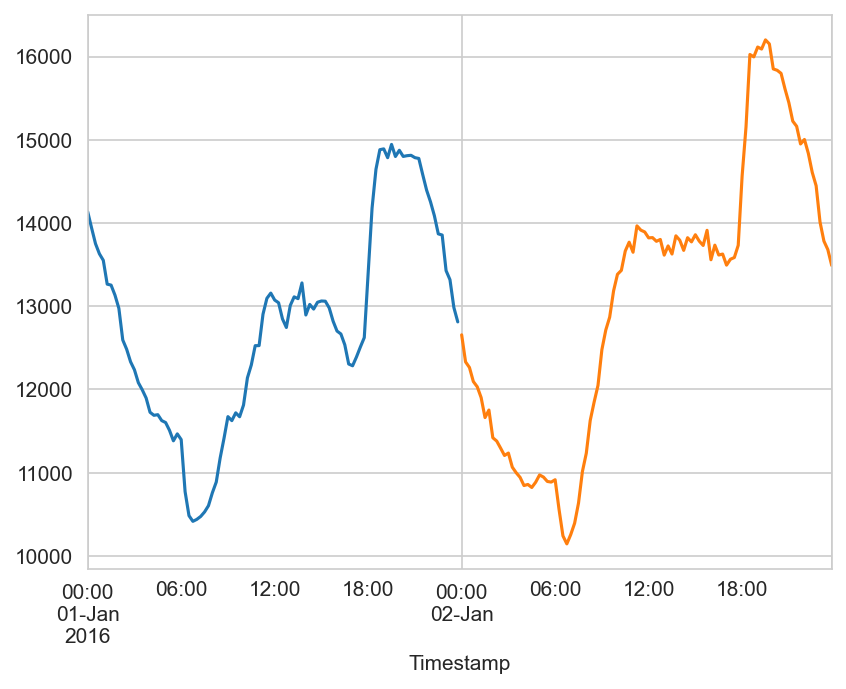

In [12]:
df['P total_SJN']['2016-01-01 00:00:00':'2016-01-01 23:45:00'].plot()
df['P total_SJN']['2016-01-02 00:00:00':'2016-01-02 23:45:00'].plot()

In [10]:
df['P total_SJN']['2016-01-01':'2016-01-02']

Timestamp
2016-01-02 23:45:00    13489.906
2016-01-02 23:30:00    13680.716
2016-01-02 23:15:00    13782.606
2016-01-02 23:00:00    14011.914
2016-01-02 22:45:00    14447.575
                         ...    
2016-01-01 01:00:00    13551.752
2016-01-01 00:45:00    13630.260
2016-01-01 00:30:00    13751.502
2016-01-01 00:15:00    13940.001
2016-01-01 00:00:00    14134.821
Name: P total_SJN, Length: 192, dtype: float64

# Unit Root Testing

To determine if the data is stationary, we first segment it into months and then weekly. Each segment is tested and visualized.

In [44]:
df_jan = df['2016-01-01':'2016-01-31']
df_feb = df['2016-02-01':]

## Weekly Stationarity

In [39]:
df_jan_wk1 = df_jan['2016-01-01':'2016-01-07']
df_jan_wk2 = df_jan['2016-01-08':'2016-01-14']
df_jan_wk3 = df_jan['2016-01-15':'2016-01-21']
df_jan_wk4 = df_jan['2016-01-22':'2016-01-29']

In [40]:
df_feb_wk1 = df['2016-01-30':'2016-02-05'] #this is due to the transition from Jan to Feb
df_feb_wk2 = df_feb['2016-02-06':'2016-02-12']
df_feb_wk3 = df_feb['2016-02-13':'2016-02-19']
df_feb_wk4 = df_feb['2016-02-20':'2016-02-26']

In [19]:
df_feb_wk1.tail()

,S total_SJN,P total_SJN,Q total_SJN,pf total_SJN
Timestamp,,,,
2016-01-30 01:00:00,11759.800,11390.617,2923.480,0.969
2016-01-30 00:45:00,12715.961,12308.572,3192.917,0.968
2016-01-30 00:30:00,12968.068,12547.708,3275.031,0.968
2016-01-30 00:15:00,13136.415,12724.683,3263.104,0.969
2016-01-30 00:00:00,13247.548,12843.784,3245.725,0.970


In [10]:
import statsmodels.tsa as tsa

In [11]:
#Testing whether the data is stationary with a daily lag.
jan_wk1_day_lg = tsa.stattools.adfuller(x=df_jan_wk1['P total_SJN'],maxlag=(24*4))
print(f'ADF Statistic: {jan_wk1_day_lg [0]}')
print(f'p-value: {jan_wk1_day_lg [1]}')
for key, value in jan_wk1_day_lg [4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.5190636697999494
p-value: 0.8882423552974658
Critial Values:
   1%, -3.4417738839904657
Critial Values:
   5%, -2.8665796253604015
Critial Values:
   10%, -2.569453974291115


The p-value is much greater than the significance level of 0.05 and hence we cannot reject the null hypothesis and thus the series is non-stationary.

In [12]:
#Testing whether the data is stationary using predefined lag
result = tsa.stattools.adfuller(x=df_jan_wk1['P total_SJN'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.4445578065513285
p-value: 0.0002473339206706742
Critial Values:
   1%, -3.4401772556197705
Critial Values:
   5%, -2.865876419242622
Critial Values:
   10%, -2.569079289056617


<AxesSubplot: xlabel='Timestamp'>

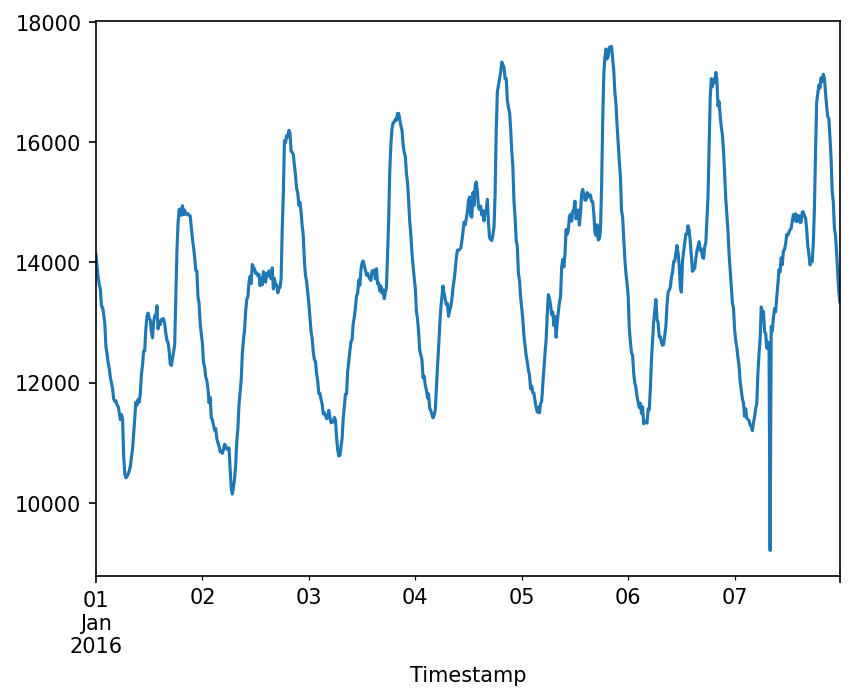

In [13]:
df_jan_wk1['P total_SJN'].plot(antialiased=True)

From the above analysis, we see that the series shows some periodicty and trend. From our preliminary unit root tests, it is shown it is not stationary at 24hr lags and hence each day's profile is differnt for the 1st week in Jan. This can be explored and quantified more later. Furthermore, time series decomoposition may assist in supporting our claims.

todo: Find a way to visualize results of stationarity tests elegantly

In [14]:
#testing stationarity with 96 samples lag
jan_wk2_day_lg =  tsa.stattools.adfuller(x=df_jan_wk2['P total_SJN'],maxlag=(24*4))
jan_wk3_day_lg =  tsa.stattools.adfuller(x=df_jan_wk3['P total_SJN'],maxlag=(24*4))
jan_wk4_day_lg =  tsa.stattools.adfuller(x=df_jan_wk4['P total_SJN'],maxlag=(24*4))

feb_wk1_day_lg =  tsa.stattools.adfuller(x=df_feb_wk1['P total_SJN'],maxlag=(24*4))
feb_wk2_day_lg =  tsa.stattools.adfuller(x=df_feb_wk2['P total_SJN'],maxlag=(24*4))
feb_wk3_day_lg =  tsa.stattools.adfuller(x=df_feb_wk3['P total_SJN'],maxlag=(24*4))
feb_wk4_day_lg =  tsa.stattools.adfuller(x=df_feb_wk4['P total_SJN'],maxlag=(24*4))


#testing stationarity with default samples lag
jan_wk1_default_lg =  tsa.stattools.adfuller(x=df_jan_wk1['P total_SJN'])
jan_wk2_default_lg =  tsa.stattools.adfuller(x=df_jan_wk2['P total_SJN'])
jan_wk3_default_lg =  tsa.stattools.adfuller(x=df_jan_wk3['P total_SJN'])
jan_wk4_default_lg =  tsa.stattools.adfuller(x=df_jan_wk4['P total_SJN'])

feb_wk1_default_lg =  tsa.stattools.adfuller(x=df_feb_wk1['P total_SJN'])
feb_wk2_default_lg =  tsa.stattools.adfuller(x=df_feb_wk2['P total_SJN'])
feb_wk3_default_lg =  tsa.stattools.adfuller(x=df_feb_wk3['P total_SJN'])
feb_wk4_default_lg =  tsa.stattools.adfuller(x=df_feb_wk4['P total_SJN'])


unit_root_day_lg_res = {'Jan Week 1':jan_wk1_day_lg,
                        'Jan Week 2':jan_wk2_day_lg,
                        'Jan Week 3':jan_wk3_day_lg,
                        'Jan Week 4':jan_wk4_day_lg,
                        'Feb Week 1':feb_wk1_day_lg,
                        'Feb Week 2':feb_wk2_day_lg,
                        'Feb Week 3':feb_wk3_day_lg,
                        'Feb Week 4':feb_wk4_day_lg}

unit_root_default_lg_res = {'Jan Week 1':jan_wk1_default_lg,
                            'Jan Week 2':jan_wk2_default_lg,
                            'Jan Week 3':jan_wk3_default_lg,
                            'Jan Week 4':jan_wk4_default_lg,
                            'Feb Week 1':feb_wk1_default_lg,
                            'Feb Week 2':feb_wk2_default_lg,
                            'Feb Week 3':feb_wk3_default_lg,
                            'Feb Week 4':feb_wk4_default_lg}

The above could probably be simplified by building a dashboard and allowing the user to input lags, and autolag methods.

In [15]:
df_uroot_day_lg = pd.DataFrame(unit_root_day_lg_res).transpose()
df_uroot_day_lg.rename(columns={0:'ADF Statistic',1:'p-value',2:'Lags Used',3:'Number of Observations',4:'Confidence Interval Results',5:'IC Results'},inplace=True)
df_uroot_day_lg['1% CI Value'] = df_uroot_day_lg['Confidence Interval Results'].apply(lambda x:x['1%'])
df_uroot_day_lg['5% CI Value'] = df_uroot_day_lg['Confidence Interval Results'].apply(lambda x:x['5%'])
df_uroot_day_lg['10% CI Value'] = df_uroot_day_lg['Confidence Interval Results'].apply(lambda x:x['10%'])
df_uroot_day_lg.drop('Confidence Interval Results',axis=1,inplace=True)

df_uroot_default_lg = pd.DataFrame(unit_root_default_lg_res).transpose()
df_uroot_default_lg.rename(columns={0:'ADF Statistic',1:'p-value',2:'Lags Used',3:'Number of Observations',4:'Confidence Interval Results',5:'IC Results'},inplace=True)
df_uroot_default_lg['1% CI Value'] = df_uroot_default_lg['Confidence Interval Results'].apply(lambda x:x['1%'])
df_uroot_default_lg['5% CI Value'] = df_uroot_default_lg['Confidence Interval Results'].apply(lambda x:x['5%'])
df_uroot_default_lg['10% CI Value'] = df_uroot_default_lg['Confidence Interval Results'].apply(lambda x:x['10%'])
df_uroot_default_lg.drop('Confidence Interval Results',axis=1,inplace=True)

,ADF Statistic,p-value,Lags Used,Number of Observations,IC Results,1% CI Value,5% CI Value,10% CI Value
Jan Week 1,-0.519064,0.888242,96,575,7518.194996,-3.441774,-2.866580,-2.569454
Jan Week 2,-4.884412,0.000037,7,664,8063.68151,-3.440237,-2.865903,-2.569093
Jan Week 3,-2.567944,0.099805,96,575,7888.913723,-3.441774,-2.866580,-2.569454
Jan Week 4,-1.047319,0.735617,96,670,8797.524108,-3.440148,-2.865863,-2.569072
Feb Week 1,-1.287749,0.634758,96,575,7935.500759,-3.441774,-2.866580,-2.569454
Feb Week 2,-1.459076,0.55365,96,575,7325.205891,-3.441774,-2.866580,-2.569454
Feb Week 3,-4.06728,0.001096,5,666,8244.352804,-3.440207,-2.865889,-2.569086
Feb Week 4,-0.936903,0.775577,96,419,5391.394135,-3.446054,-2.868463,-2.570458


In [77]:
df_uroot_default_lg

,ADF Statistic,p-value,Lags Used,Number of Observations,IC Results,1% CI Value,5% CI Value,10% CI Value
Jan Week 1,-4.444558,0.000247,3,668,9197.968426,-3.440177,-2.865876,-2.569079
Jan Week 2,-4.884412,0.000037,7,664,9092.881216,-3.440237,-2.865903,-2.569093
Jan Week 3,-4.699714,0.000084,2,669,8907.176678,-3.440163,-2.865870,-2.569076
Jan Week 4,-5.517119,0.000002,9,757,9998.735666,-3.439018,-2.865366,-2.568807
Feb Week 1,-4.35081,0.000362,7,664,9313.986626,-3.440237,-2.865903,-2.569093
Feb Week 2,-4.347782,0.000367,3,668,8471.714544,-3.440177,-2.865876,-2.569079
Feb Week 3,-4.06728,0.001096,5,666,9278.134803,-3.440207,-2.865889,-2.569086
Feb Week 4,-4.254279,0.000533,4,511,6509.709726,-3.443212,-2.867213,-2.569791


## Monthly Stationarity

In [17]:
jan_daily_lg =  tsa.stattools.adfuller(x=df_jan['P total_SJN'],maxlag=(24*4))
feb_daily_lg =  tsa.stattools.adfuller(x=df_feb['P total_SJN'],maxlag=(24*4))

jan_default_lg =  tsa.stattools.adfuller(x=df_jan['P total_SJN'])
feb_default_lg =  tsa.stattools.adfuller(x=df_feb['P total_SJN'])


unit_root_mthly_lg_res = {'Jan Daily Lag':jan_daily_lg,
                            'Feb Daily Lag':feb_daily_lg,
                            'Jan Default Lag':jan_default_lg,
                            'Feb Default Lag':feb_default_lg,}


df_uroot_mthly_lg = pd.DataFrame(unit_root_mthly_lg_res).transpose()
df_uroot_mthly_lg.rename(columns={0:'ADF Statistic',1:'p-value',2:'Lags Used',3:'Number of Observations',4:'Confidence Interval Results',5:'IC Results'},inplace=True)
df_uroot_mthly_lg['1% CI Value'] = df_uroot_mthly_lg['Confidence Interval Results'].apply(lambda x:x['1%'])
df_uroot_mthly_lg['5% CI Value'] = df_uroot_mthly_lg['Confidence Interval Results'].apply(lambda x:x['5%'])
df_uroot_mthly_lg['10% CI Value'] = df_uroot_mthly_lg['Confidence Interval Results'].apply(lambda x:x['10%'])
df_uroot_mthly_lg.drop('Confidence Interval Results',axis=1,inplace=True)

In [79]:
df_uroot_mthly_lg

,ADF Statistic,p-value,Lags Used,Number of Observations,IC Results,1% CI Value,5% CI Value,10% CI Value
Jan Daily Lag,-4.476293,0.000217,96,2878,39644.020645,-3.432624,-2.862545,-2.567305
Feb Daily Lag,-1.991636,0.290252,96,2243,30448.284822,-3.433269,-2.862829,-2.567456
Jan Default Lag,-10.044726,0.0,12,2962,41047.617425,-3.432560,-2.862516,-2.567290
Feb Default Lag,-8.781113,0.0,13,2326,31783.227944,-3.433165,-2.862783,-2.567432


For small lags, the series is stationary and this can be used fore characterizing the time-series. I am not sure how, but there must exist a way to describe the shape of the time-series using the assumption of stationarity. Possibly, the mean over the lags, albeit the lags are very small.

# Structural Time Series Analysis

Revisiting this problem, I would like to see if the time series can be decomposed into structural components in an attempt to characterize it.

In [12]:
mpl.style.use('default')
plt.rc("figure",figsize=(20,20))

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose(df, column_name):
    """
    A function that returns the trend, seasonality and residual captured by applying both multiplicative and
    additive model.
    df -> DataFrame
    column_name -> column_name for which trend, seasonality is to be captured
    """
    #et = pd.tseries.frequencies.to_offset("-15T")
    et=int(24*60/15)
    result_mul = seasonal_decompose(df[column_name], model='multiplicative', period=et) #for this case
    result_add = seasonal_decompose(df[column_name], model = 'additive', period=et)

    #plt.rcParams.update({'figure.figsize': (20, 10)})
    result_mul.plot().suptitle('Multiplicative Decompose', fontsize=16)
    result_add.plot().suptitle('Additive Decompose', fontsize=16)
    plt.grid()
    
    return result_mul, result_add

(<statsmodels.tsa.seasonal.DecomposeResult at 0x1f53c87c130>,
 <statsmodels.tsa.seasonal.DecomposeResult at 0x1f53c46fdf0>)

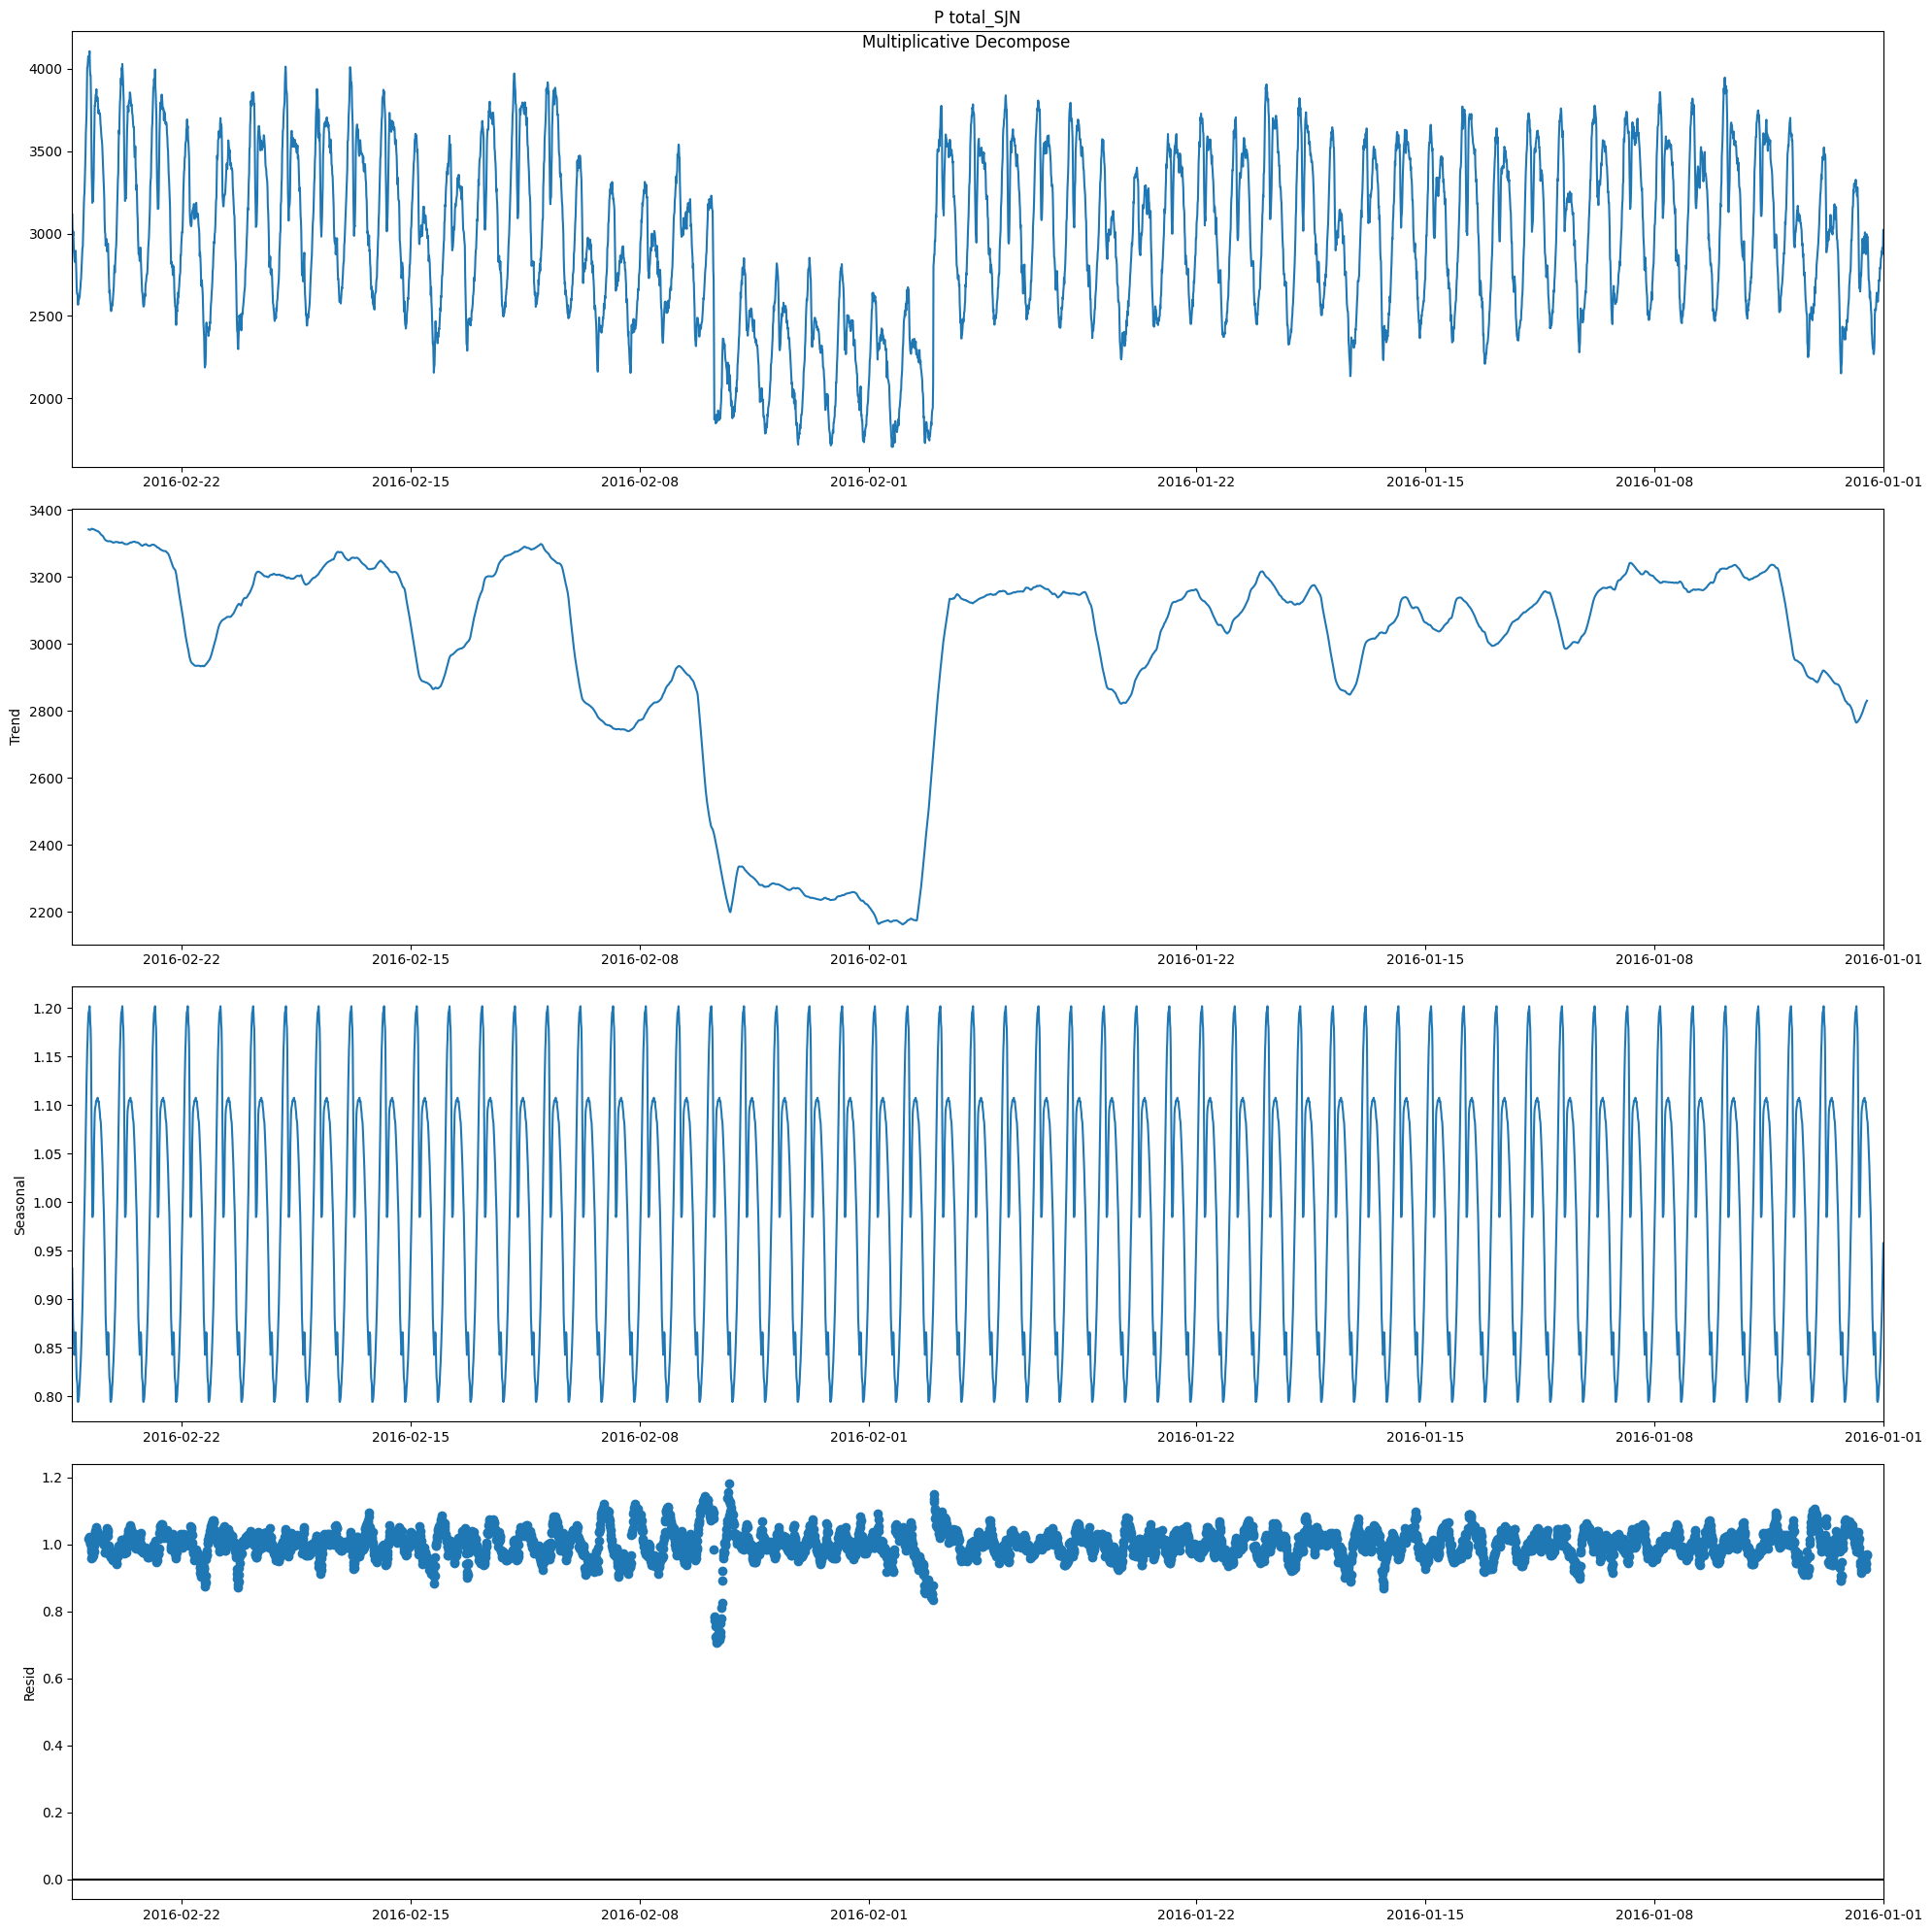

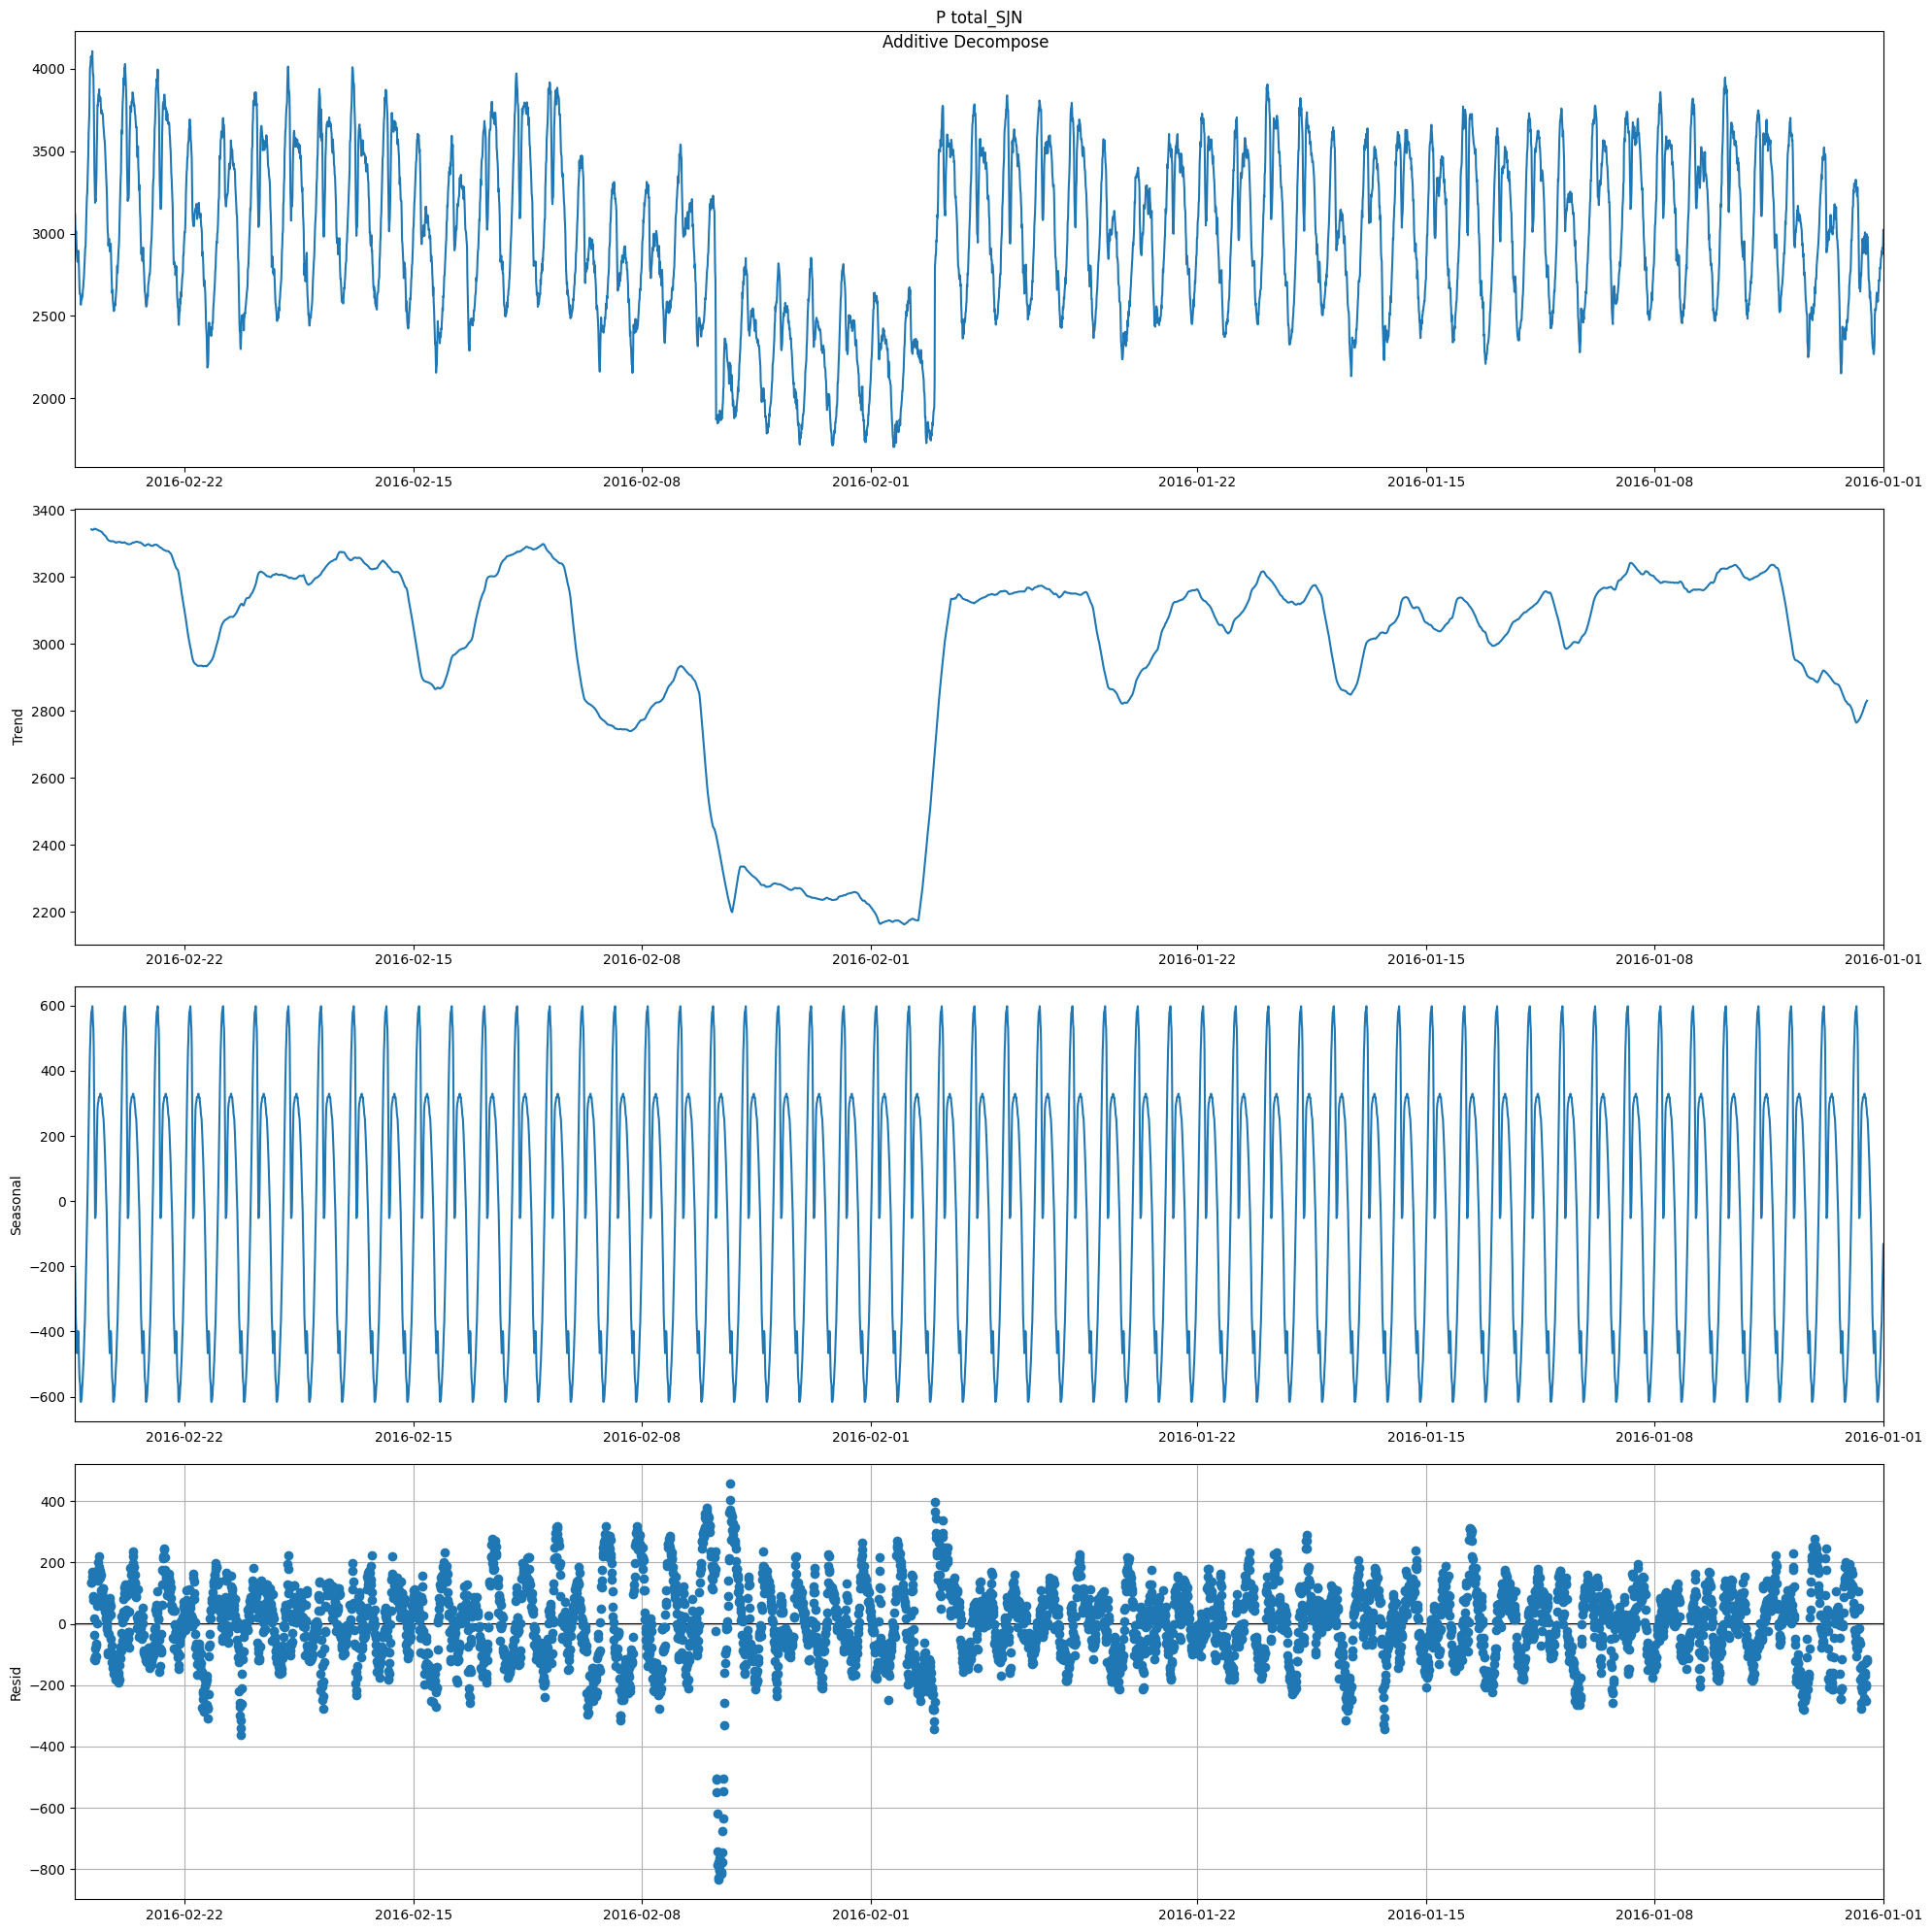

In [14]:
#preprocessing to convert timestamp to datetime index
decompose(df_proc, 'P total_SJN')

## Seasonality analysis

There is a clear general cycle that can be seen from the data after the trend and residuals are removed. This can be used as a general utilization profile.

In [ ]:
#Insert code

## Investigating General Load Profiles

As a starting point, use prof hossein's approach for finding daily load profiles. Look at the variation of the load for the monday and find a formula for the variation. Do this for each weekday for both Jan and Feb. I would like to account for the trend shift seen in the decomposition.

In [ ]:
#group data by weekday
df_proc_grp = df_proc.copy()
df_proc_grp['weekday'] = df_proc_grp.index.day_of_week
grp_bases = df_proc_grp['P total_SJN'].resample('D').mean().groupby(df_proc_grp.index.day_of_week)

#df_proc.resample('D').mean()

To avoid wasting time on the above code, I'll mannually check the means for the weekdays in January and February to see how far they are apart. After this I'll
attempt to find the daily variation on the days by creating a new time series.

In [59]:
df_daily_means = df_proc.resample('D').mean()
df_daily_means['weekdays'] = df_daily_means.index.day_name()
df_daily_means.to_csv('feeder_with_wdays_lbl.csv')

# Curve Fitting 

I will attempt to fit load profiles for each day of the month

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [80]:
df_jan = df_proc['2016-01-01':'2016-01-31']['P total_SJN']
df_jan_wk1 = df_jan['2016-01-01':'2016-01-07']
df_jan_wk2 = df_jan['2016-01-08':'2016-01-14']
df_jan_wk3 = df_jan['2016-01-15':'2016-01-21']
df_jan_wk4 = df_jan['2016-01-22':'2016-01-29']

#reg = LinearRegression().fit(df, y)
df_jan_wk1

Timestamp
2016-01-31 23:45:00    10641.913
2016-01-31 23:30:00    10882.418
2016-01-31 23:15:00    11133.149
2016-01-31 23:00:00    11323.484
2016-01-31 22:45:00    11387.351
                         ...    
2016-01-01 01:00:00    13551.752
2016-01-01 00:45:00    13630.260
2016-01-01 00:30:00    13751.502
2016-01-01 00:15:00    13940.001
2016-01-01 00:00:00    14134.821
Freq: -15T, Name: P total_SJN, Length: 2976, dtype: float64

In [85]:
dfjw1 = pd.DataFrame(df_jan_wk1).reset_index()
dfjw1['index'] = dfjw1.index


,Timestamp,P total_SJN,index
0,2016-01-07 23:45:00,13340.362,0
1,2016-01-07 23:30:00,13503.085,1
2,2016-01-07 23:15:00,13809.093,2
3,2016-01-07 23:00:00,14155.986,3
4,2016-01-07 22:45:00,14449.414,4
...,...,...,...
667,2016-01-01 01:00:00,13551.752,667
668,2016-01-01 00:45:00,13630.260,668
669,2016-01-01 00:30:00,13751.502,669
670,2016-01-01 00:15:00,13940.001,670


<AxesSubplot: >

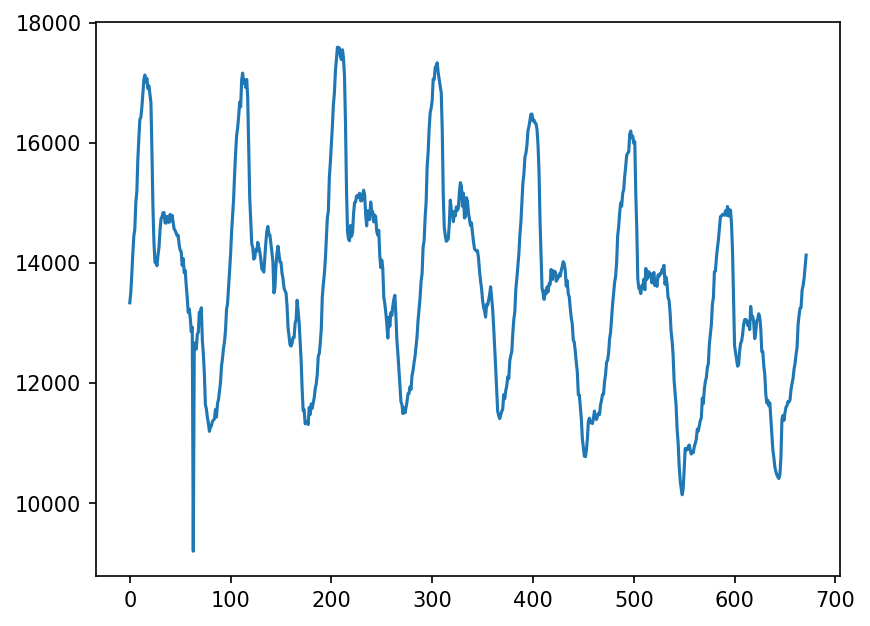

In [86]:
dfjw1['P total_SJN'].plot()

In [91]:
reg = LinearRegression().fit(np.array(dfjw1['index']).reshape(-1, 1), np.array(dfjw1['P total_SJN']).reshape(-1, 1))

In [122]:
x = dfjw1.loc[dfjw1['index'].isin(range( int((24*60)/15),  int(2*((24*60)/15))))] #Values for Jan 6th 
x = x.drop('index',axis=1)
x.sort_index(ascending=False,inplace=True)

In [123]:
x['index'] = range(0,len(x.index))
x.head()

,Timestamp,P total_SJN,index
191,2016-01-06 00:00:00,13438.040,0
190,2016-01-06 00:15:00,12907.674,1
189,2016-01-06 00:30:00,12674.354,2
188,2016-01-06 00:45:00,12495.676,3
187,2016-01-06 01:00:00,12452.769,4


In [127]:
#preparing data
x_index = np.array(x['index'])
y = np.array(x['P total_SJN'])

[-5.61953182e-05  1.29256451e-02 -1.07457784e+00  3.89711913e+01
 -5.24069362e+02  1.37232825e+04]
[-2.53581707e-07  1.60754682e-05  5.13930355e-03 -6.82246021e-01
  2.97706271e+01 -4.39329645e+02  1.35515501e+04]
[ 2.89205855e-08 -9.86967637e-06  1.27889839e-03 -7.78180054e-02
  2.15818340e+00 -1.79193119e+01 -1.17754997e+02  1.30822443e+04]
[ 1.68120571e-09 -6.09937583e-07  8.91248713e-05 -6.75461530e-03
  2.86640055e-01 -6.95937614e+00  9.73313397e+01 -7.09454916e+02
  1.37224524e+04]
[ 5.35096161e-11 -2.11941552e-08  3.47599375e-06 -3.06013348e-04
  1.56490285e-02 -4.66414976e-01  7.47518907e+00 -4.50718192e+01
 -1.36191729e+02  1.32531908e+04]
[-1.34279967e-12  6.91339460e-10 -1.50226956e-07  1.79699720e-05
 -1.29394117e-03  5.75768050e-02 -1.55956593e+00  2.40839905e+01
 -1.76482178e+02  2.88249485e+02  1.29866835e+04]
[-8.66720114e-14  4.39433263e-11 -9.54321150e-09  1.15973893e-06
 -8.64538381e-05  4.07566188e-03 -1.20801749e-01  2.16727938e+00
 -2.19649655e+01  1.22061556e+02 

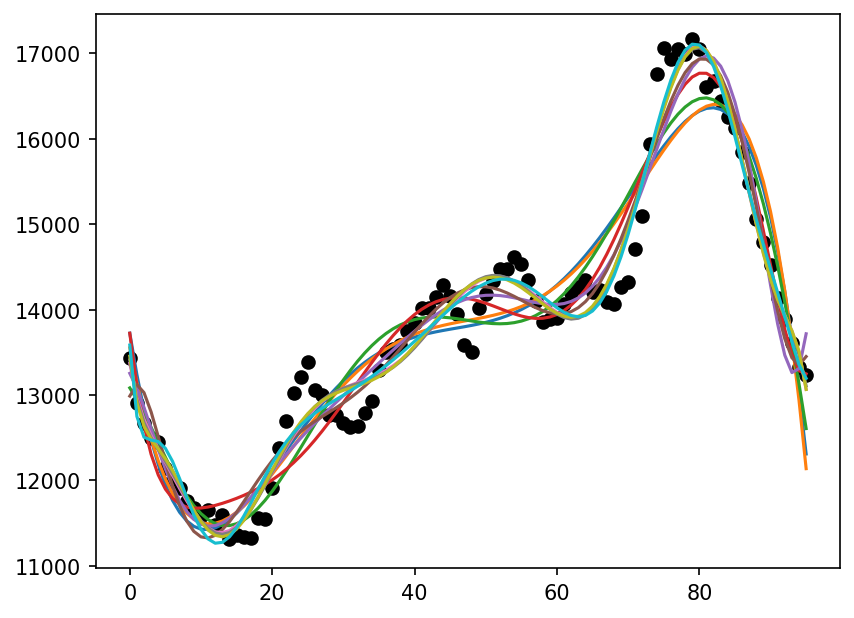

In [139]:
#plotting original data
plt.plot(x_index,y, 'ok')

#fitting polynomials
startorder = 5
endorder = 15
error_scores = {}
for model_order in range(startorder, endorder, 1):
    # Finding the Model
    p = np.polyfit(x_index, y, model_order)
    print(p)
    # Plot the Model
    ymodel = np.polyval(p, x_index) 
    error_scores[model_order] = np.sqrt(sum((y - ymodel)**2))
    plt.plot(x_index,ymodel)

TODO: Need to calculate RMSE and divergence of each day and see which order polynomial is most used, then see what the error is for each day using
the general polynomial found

In [140]:
error_scores

{5: 4693.949045752803,
 6: 4657.867554033471,
 7: 4378.156176650704,
 8: 3776.7141099559085,
 9: 3379.0582771471086,
 10: 3224.0533707227596,
 11: 2822.3423280215393,
 12: 2816.674957291074,
 13: 2808.9054592450548,
 14: 2716.557802830131}

# January Feeder Analaysis

To determine the load profiles for each day of the week. I want to determine the interday variation for each weekday. Of interest is the autocorrelation and partial autocorrelation of different weekdays. Eg. ACF(Monday,Wednesday) and PACF(Monday,Wednesday). The PACF will ignore the effect of Tuesday and soley focus is on Monday's effect on Wednesday. To determine the correlation effect, I will need to do this for each week. An alternative way of testing is to lag each weekday against monday and look at the variation. This is mannually doing ACF and PACF which is a bit silly. It makes sense if I am attempting to visually inspect dissimilarity or RMSE.

Hence the objectives in this section are:
<ol>
<li>Generate ACF and PACF investigating weekday similarity for each week</li>
<li>Investigate difference in daily variation of time series by lagging weekdays against monday and looking as well as quantifying the error between series using a distance metric</li>
<li>Construct Periodogram and PSD</li>
<li>Compare error in polynomial fits both visually and using the RMSE</li>
<li>Comment on TS Decomposition</li>
<li> Apply Matrix Profile to Data to investigate recurring morphologies
</ol>

In [ ]:
#setting up containers to store data
jan_wk1,jan_wk2,jan_wk3,jan_wk4 = [],[],[],[]
jan = [jan_wk1,jan_wk2,jan_wk3,jan_wk4]

feb_wk1,feb_wk2,feb_wk3,feb_wk4 = [],[],[],[]
feb = [feb_wk1,feb_wk2,feb_wk3,feb_wk4]

#Splitting data into each weekday 

jan_start = df_proc[0]

#Finding the polynomial fits

#comparing the errors